# Granger Causality Analysis for Infant EEG Data

This notebook performs Granger causality analysis on infant EEG data to identify causal relationships between different brain regions. Granger causality measures whether one time series can predict another time series better than the series can predict itself.

## Analysis Steps:
1. Load and preprocess EEG data
2. Calculate Granger causality for all channel pairs
3. Visualize results as connectivity matrices and networks
4. Statistical analysis and significance testing

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import networkx as nx
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preprocessing

In [128]:
def load_eeg_data(file_path):
    """
    Load EEG data from EDF file and preprocess it
    """
    # Load the EDF file
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    
    # Get basic info
    print(f"Sampling frequency: {raw.info['sfreq']} Hz")
    print(f"Number of channels: {len(raw.ch_names)}")
    print(f"Channel names: {raw.ch_names}")
    print(f"Duration: {raw.times[-1]:.2f} seconds")
    
    return raw

# Load the data
data_path = './Dataset/Infants_data/NORB00064/sub-NORB00064_ses-3_task-EEG_eeg.edf'
raw = load_eeg_data(data_path)

Sampling frequency: 200.0 Hz
Number of channels: 19
Channel names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
Duration: 328.00 seconds


In [129]:
import os
import re

def extract_subject_id(file_path):
    """
    Extract subject ID from EEG file path
    Expected format: sub-NORB00001_ses-1_task-EEG_eeg.edf
    """
    filename = os.path.basename(file_path)
    # Extract subject ID and session using regex
    match = re.search(r'sub-([^_]+)_ses-(\d+)', filename)
    if match:
        subject_part = match.group(1)  # NORB00064
        session_part = match.group(2)  # 1
        return f"{subject_part}_ses{session_part}"  # NORB00064_ses1
    else:
        # Fallback: use filename without extension
        return os.path.splitext(filename)[0]

def setup_output_directory(subject_id, base_output_dir='./Dataset/Infants_data_output'):
    """
    Create subject-specific output directory
    """
    subject_output_dir = os.path.join(base_output_dir, subject_id)
    os.makedirs(subject_output_dir, exist_ok=True)
    print(f"Output directory created: {subject_output_dir}")
    return subject_output_dir

# Extract subject ID and setup output directory
subject_id = extract_subject_id(data_path)
output_dir = setup_output_directory(subject_id)
print(f"Subject ID: {subject_id}")
print(f"All outputs will be saved to: {output_dir}")

Output directory created: ./Dataset/Infants_data_output/NORB00064_ses3
Subject ID: NORB00064_ses3
All outputs will be saved to: ./Dataset/Infants_data_output/NORB00064_ses3


In [130]:
def preprocess_eeg_detailed(raw, lowpass=30, highpass=0.5):
    """
    Preprocess EEG data with detailed channel classification
    """
    # Make a copy to avoid modifying original data
    raw_filtered = raw.copy()
    
    # Apply bandpass filter
    raw_filtered.filter(highpass, lowpass, fir_design='firwin', verbose=False)
    
    # Remove bad channels if any
    raw_filtered.info['bads'] = []
    
    # Get the data as numpy array
    data, times = raw_filtered[:, :]
    
    # Get all channel names
    ch_names = raw_filtered.ch_names
    
    # Classify channels
    eeg_channels = []
    reference_channels = []
    artifact_channels = []
    other_channels = []
    
    # Standard EEG electrode names
    standard_eeg_names = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ', 'C3', 'C4', 'CZ', 
                         'P3', 'P4', 'PZ', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2']
    
    for i, ch in enumerate(ch_names):
        if 'Pg' in ch or 'REF' in ch.upper() or 'GND' in ch.upper():
            reference_channels.append(ch)
        elif any(artifact_keyword in ch.upper() for artifact_keyword in ['ECG', 'EOG', 'EMG']):
            artifact_channels.append(ch)
        elif ch in standard_eeg_names or any(eeg_name in ch for eeg_name in standard_eeg_names):
            eeg_channels.append((i, ch))
        else:
            other_channels.append(ch)
    
    # Extract indices and names for EEG channels
    good_channel_indices = [idx for idx, name in eeg_channels]
    ch_names_clean = [name for idx, name in eeg_channels]
    
    # Extract clean data
    data_clean = data[good_channel_indices, :]
    
    print("=== CHANNEL CLASSIFICATION ===")
    print(f"Total channels: {len(ch_names)}")
    print(f"All channels: {ch_names}")
    print()
    print(f"EEG channels ({len(eeg_channels)}): {ch_names_clean}")
    print(f"Reference channels ({len(reference_channels)}): {reference_channels}")
    print(f"Artifact channels ({len(artifact_channels)}): {artifact_channels}")
    print(f"Other channels ({len(other_channels)}): {other_channels}")
    print()
    print(f"Final data shape: {data_clean.shape}")
    
    return data_clean, ch_names_clean, times
# Preprocess the data
eeg_data, channel_names, times = preprocess_eeg_detailed(raw)
sampling_freq = raw.info['sfreq']

=== CHANNEL CLASSIFICATION ===
Total channels: 19
All channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']

EEG channels (19): ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
Reference channels (0): []
Artifact channels (0): []
Other channels (0): []

Final data shape: (19, 65600)


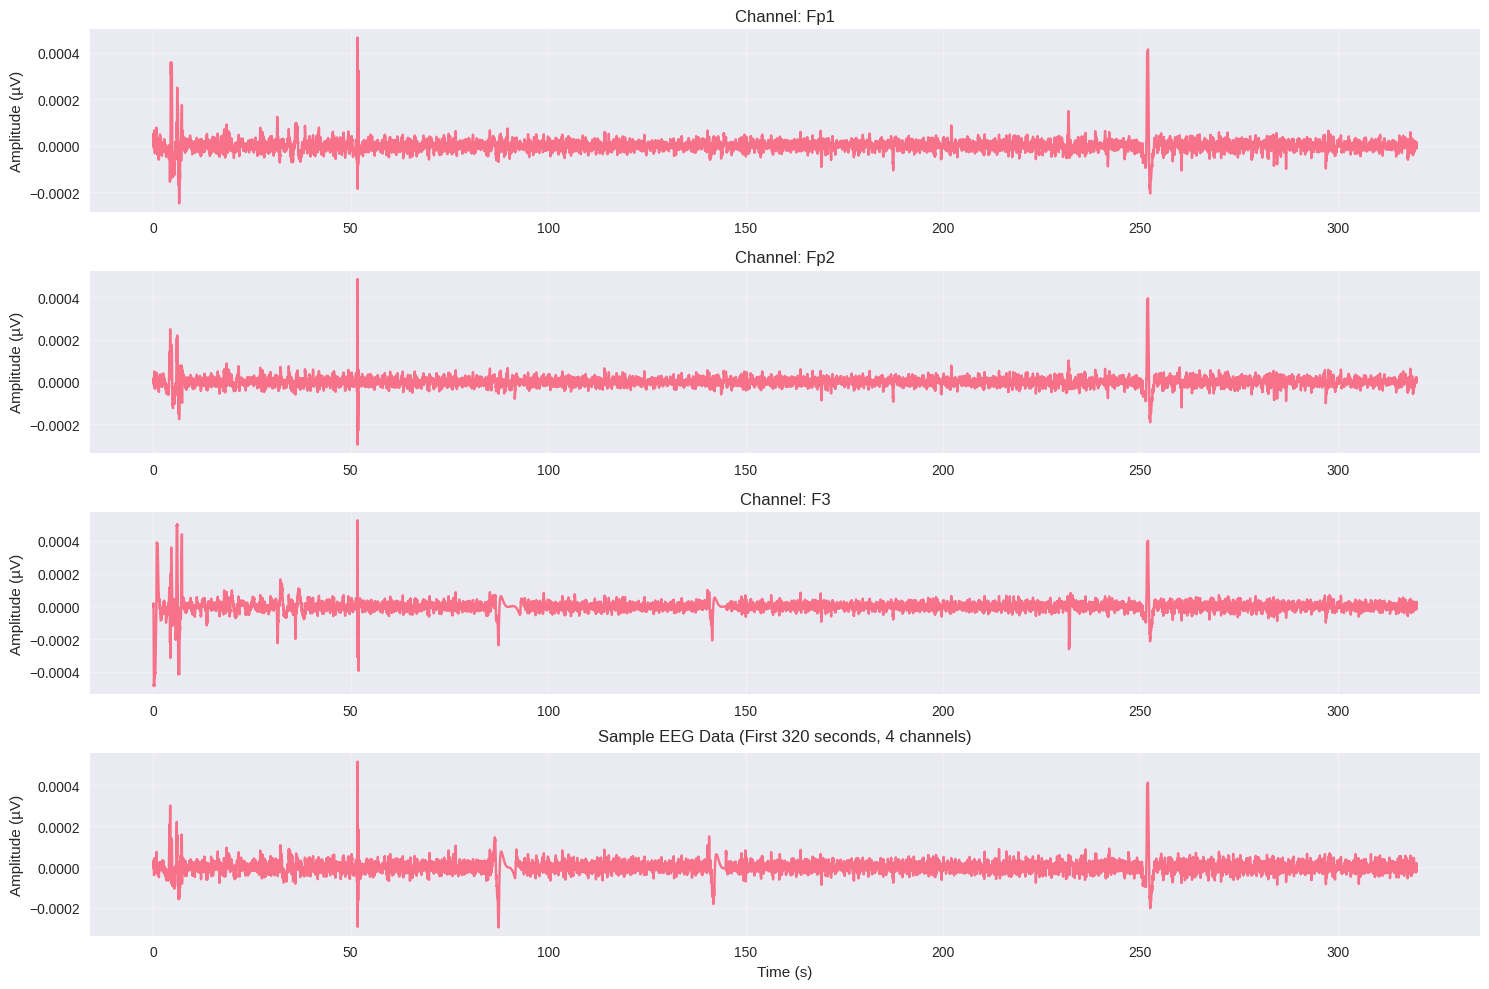

In [131]:
# Visualize a subset of the EEG data
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
time_window = slice(0, int(320 * sampling_freq))  # First 10 seconds
times_arr = np.array(times)
time_axis = times_arr[time_window]

# Plot first 4 channels
for i in range(4):
    axes[i].plot(time_axis, eeg_data[i, time_window])
    axes[i].set_title(f'Channel: {channel_names[i]}')
    axes[i].set_ylabel('Amplitude (µV)')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.title('Sample EEG Data (First 320 seconds, 4 channels)', y=1.02)

# Save the plot
plt.savefig(os.path.join(output_dir, 'eeg_sample_data.png'), dpi=300, bbox_inches='tight')
plt.show()

## 2. Granger Causality Analysis Functions

In [132]:
def calculate_granger_causality(data, channel_names, max_lag=10, alpha=0.05):
    """
    Calculate Granger causality between all pairs of channels
    
    Parameters:
    -----------
    data : numpy array
        EEG data (channels x time)
    channel_names : list
        Names of channels
    max_lag : int
        Maximum lag to test
    alpha : float
        Significance level
    
    Returns:
    --------
    gc_matrix : numpy array
        Granger causality matrix
    p_values : numpy array
        P-values matrix
    """
    n_channels = len(channel_names)
    gc_matrix = np.zeros((n_channels, n_channels))
    p_values = np.ones((n_channels, n_channels))
    
    print(f"Calculating Granger causality for {n_channels} channels...")
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:  # Don't test self-causality
                try:
                    # Prepare data for Granger test
                    # X causes Y: data should be [Y, X]
                    test_data = np.column_stack([data[j, :], data[i, :]])
                    
                    # Perform Granger causality test
                    result = grangercausalitytests(test_data, max_lag, verbose=False)
                    
                    # Extract F-statistic and p-value for optimal lag
                    best_lag = 1
                    min_p = 1.0
                    best_f = 0.0
                    
                    for lag in range(1, max_lag + 1):
                        f_stat = result[lag][0]['ssr_ftest'][0]
                        p_val = result[lag][0]['ssr_ftest'][1]
                        
                        if p_val < min_p:
                            min_p = p_val
                            best_f = f_stat
                            best_lag = lag
                    
                    gc_matrix[i, j] = best_f
                    p_values[i, j] = min_p
                    
                except Exception as e:
                    print(f"Error calculating GC from {channel_names[i]} to {channel_names[j]}: {e}")
                    gc_matrix[i, j] = 0
                    p_values[i, j] = 1
    
    return gc_matrix, p_values

def apply_significance_threshold(gc_matrix, p_values, alpha=0.05):
    """
    Apply significance threshold to Granger causality matrix
    """
    significant_gc = gc_matrix.copy()
    significant_gc[p_values > alpha] = 0
    return significant_gc

In [133]:
# Downsample data for faster computation (optional)
def downsample_data(data, original_fs, target_fs=100):
    """
    Downsample EEG data to reduce computational load with proper resampling
    """
    if original_fs <= target_fs:
        return data, original_fs
    
    from scipy import signal
    
    # Calculate exact resampling ratio
    downsample_ratio = target_fs / original_fs
    
    # Use scipy's resample for proper anti-aliasing and exact target frequency
    n_samples_new = int(data.shape[1] * downsample_ratio)
    
    # Resample each channel
    data_resampled = np.zeros((data.shape[0], n_samples_new))
    for ch_idx in range(data.shape[0]):
        data_resampled[ch_idx, :] = signal.resample(data[ch_idx, :], n_samples_new)
    
    print(f"Resampled from {original_fs} Hz to {target_fs} Hz")
    print(f"New data shape: {data_resampled.shape}")
    
    return data_resampled, target_fs

# Downsample for faster computation
eeg_downsampled, new_fs = downsample_data(eeg_data, sampling_freq, target_fs=100)

# Use a subset of data for demonstration (first 60 seconds)
max_samples = int(320 * new_fs)  # 320 seconds
if eeg_downsampled.shape[1] > max_samples:
    eeg_subset = eeg_downsampled[:, :max_samples]
    print(f"Using first 320 seconds of data: {eeg_subset.shape}")
else:
    eeg_subset = eeg_downsampled
    print(f"Using all available data: {eeg_subset.shape}")

Resampled from 200.0 Hz to 100 Hz
New data shape: (19, 32800)
Using first 320 seconds of data: (19, 32000)


In [134]:
# Calculate Granger causality
print("Starting Granger causality analysis...")
print("This may take a few minutes...")

gc_matrix, p_values = calculate_granger_causality(
    eeg_subset,  # Using downsampled data, Change to eeg_data to use original data
    channel_names, 
    max_lag=2,  # Reduced for faster computation
    alpha=0.05
)

# Apply significance threshold
significant_gc = apply_significance_threshold(gc_matrix, p_values, alpha=0.05)

print("Granger causality analysis completed!")
print(f"Number of significant connections: {np.sum(significant_gc > 0)}")
print(f"Total possible connections: {len(channel_names) * (len(channel_names) - 1)}")

Starting Granger causality analysis...
This may take a few minutes...
Calculating Granger causality for 19 channels...
Granger causality analysis completed!
Number of significant connections: 337
Total possible connections: 342


## 3. Visualization of Results

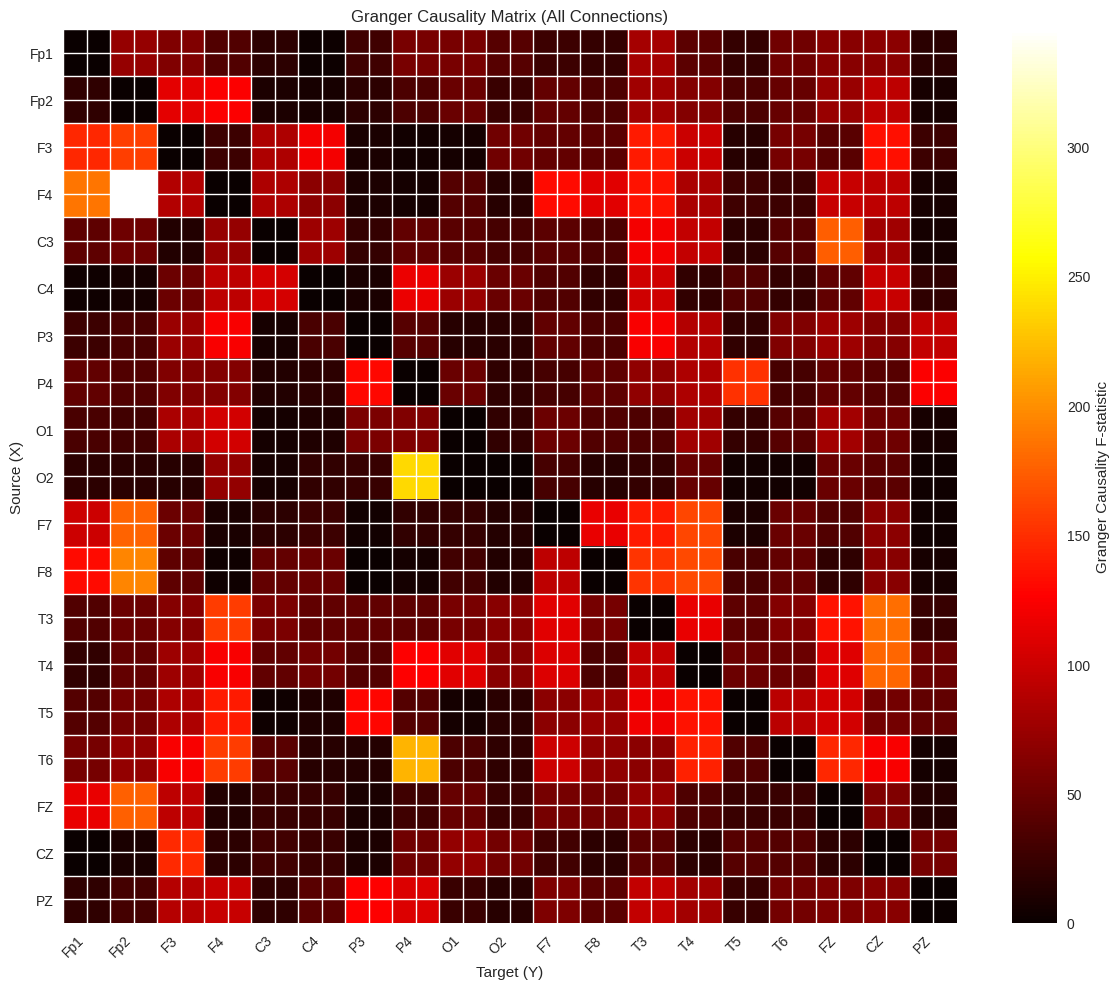

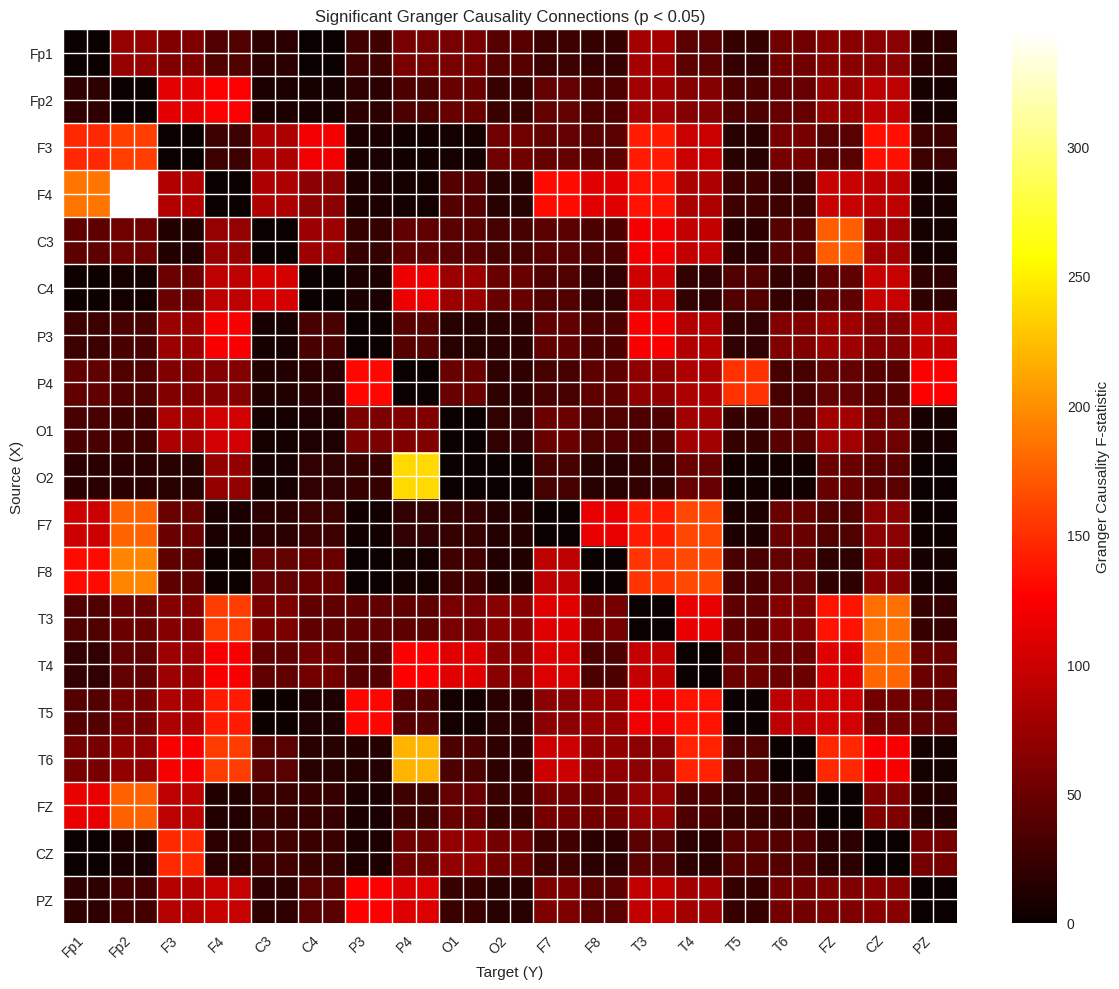

In [135]:
def plot_connectivity_matrix(matrix, channel_names, title, cmap='viridis', figsize=(12, 10), save_path=None):
    """
    Plot connectivity matrix as heatmap
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(matrix, cmap=cmap, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(range(len(channel_names)))
    ax.set_yticks(range(len(channel_names)))
    ax.set_xticklabels(channel_names, rotation=45, ha='right')
    ax.set_yticklabels(channel_names)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Granger Causality F-statistic')
    
    # Labels and title
    ax.set_xlabel('Target (Y)')
    ax.set_ylabel('Source (X)')
    ax.set_title(title)
    
    # Add grid
    ax.set_xticks(np.arange(len(channel_names)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(channel_names)) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Plot original GC matrix
fig1 = plot_connectivity_matrix(
    gc_matrix, 
    channel_names, 
    'Granger Causality Matrix (All Connections)',
    cmap='hot',
    save_path=os.path.join(output_dir, 'gc_matrix_all_connections.png')
)
plt.show()

# Plot significant connections only
fig2 = plot_connectivity_matrix(
    significant_gc, 
    channel_names, 
    'Significant Granger Causality Connections (p < 0.05)',
    cmap='hot',
    save_path=os.path.join(output_dir, 'gc_matrix_significant_connections.png')
)
plt.show()

Network contains 19 nodes and 17 edges


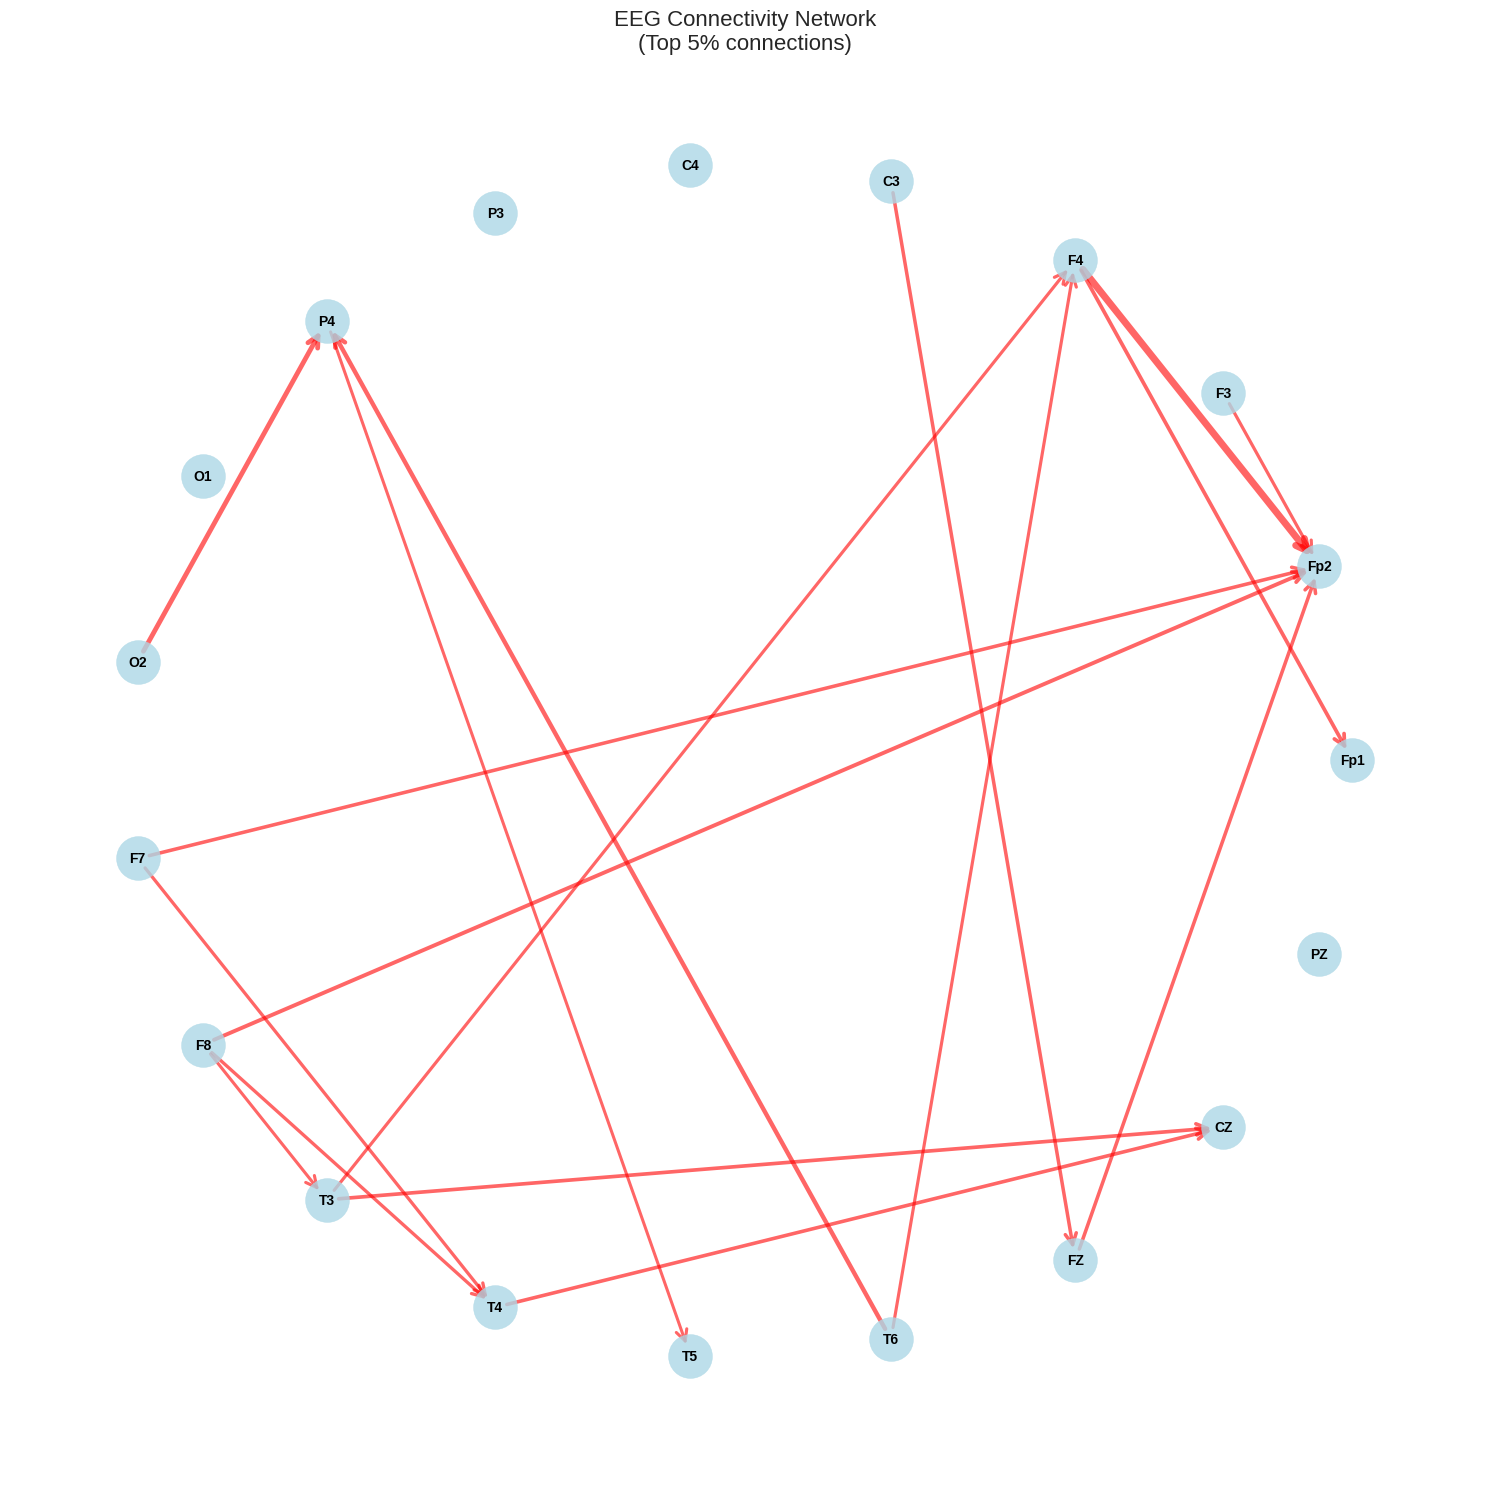

In [136]:
def plot_connectivity_network(gc_matrix, channel_names, threshold_percentile=80, figsize=(15, 15), save_path=None):
    """
    Plot connectivity as a network graph
    """
    # Create a copy and apply threshold
    threshold = np.percentile(gc_matrix[gc_matrix > 0], threshold_percentile)
    thresholded_matrix = gc_matrix.copy()
    thresholded_matrix[thresholded_matrix < threshold] = 0
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes
    for i, name in enumerate(channel_names):
        G.add_node(name)
    
    # Add edges
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            if thresholded_matrix[i, j] > 0:
                G.add_edge(channel_names[i], channel_names[j], 
                          weight=thresholded_matrix[i, j])
    
    # Create layout
    plt.figure(figsize=figsize)
    
    # Use circular layout for EEG electrodes
    pos = nx.circular_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue', 
                          node_size=1000, 
                          alpha=0.8)
    
    # Draw edges with thickness proportional to connection strength
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    if weights:  # Only draw if there are edges
        weights_normalized = np.array(weights) / max(weights) * 5  # Scale for visibility
        
        nx.draw_networkx_edges(G, pos, 
                              width=weights_normalized,
                              alpha=0.6,
                              edge_color='red',
                              arrows=True,
                              arrowsize=20,
                              arrowstyle='->')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f'EEG Connectivity Network\n(Top {100-threshold_percentile}% connections)', 
              fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"Network contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    return G

# Plot network
G = plot_connectivity_network(
    significant_gc, 
    channel_names, 
    threshold_percentile=95,
    save_path=os.path.join(output_dir, 'connectivity_network.png')
)
plt.show()

## 4. Statistical Analysis and Summary

=== CONNECTIVITY ANALYSIS SUMMARY ===
Total possible connections: 342
Significant connections (p < 0.05): 337
Percentage significant: 98.54%

=== NODE-WISE ANALYSIS ===
   Channel  Out-degree  In-degree  Total_degree
1      Fp2          18         18            36
2       F3          18         18            36
3       F4          18         18            36
16      FZ          18         18            36
4       C3          18         18            36
10      F7          18         18            36
7       P4          18         18            36
15      T6          18         18            36
14      T5          18         18            36
13      T4          18         18            36
12      T3          18         18            36
17      CZ          17         18            35
8       O1          18         17            35
5       C4          18         17            35
6       P3          18         17            35
18      PZ          18         17            35
11      F8     

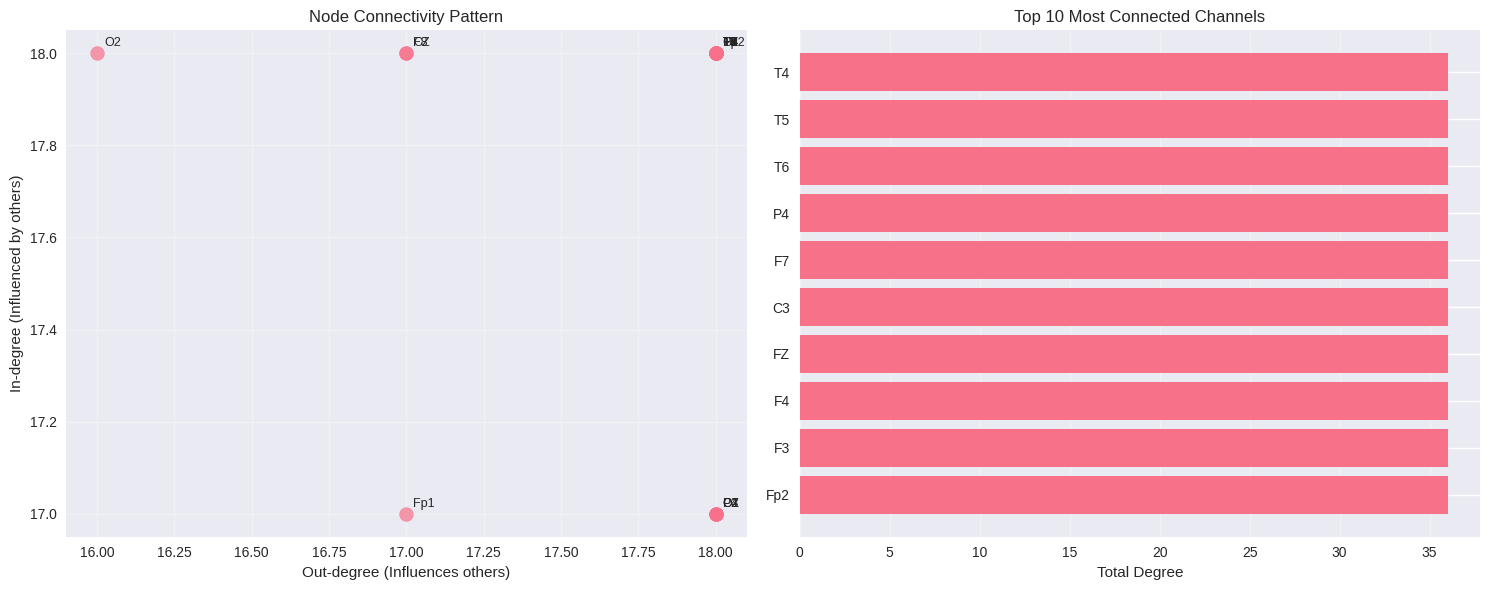

In [137]:
def analyze_connectivity_statistics(gc_matrix, p_values, channel_names, alpha=0.05, save_dir=None):
    """
    Perform statistical analysis of connectivity results
    """
    # Basic statistics
    total_connections = len(channel_names) * (len(channel_names) - 1)
    significant_connections = np.sum(p_values < alpha)
    
    print("=== CONNECTIVITY ANALYSIS SUMMARY ===")
    print(f"Total possible connections: {total_connections}")
    print(f"Significant connections (p < {alpha}): {significant_connections}")
    print(f"Percentage significant: {significant_connections/total_connections*100:.2f}%")
    print()
    
    # Node-wise analysis
    print("=== NODE-WISE ANALYSIS ===")
    
    # Out-degree (how many channels this channel influences)
    out_degree = np.sum(p_values < alpha, axis=1)
    # In-degree (how many channels influence this channel)
    in_degree = np.sum(p_values < alpha, axis=0)
    
    node_stats = pd.DataFrame({
        'Channel': channel_names,
        'Out-degree': out_degree,
        'In-degree': in_degree,
        'Total_degree': out_degree + in_degree
    })
    
    node_stats = node_stats.sort_values('Total_degree', ascending=False)
    print(node_stats)
    print()
    
    # Top connections
    print("=== TOP 10 STRONGEST CONNECTIONS ===")
    connections = []
    connections_df = None
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            if i != j and p_values[i, j] < alpha:
                connections.append({
                    'Source': channel_names[i],
                    'Target': channel_names[j],
                    'F-statistic': gc_matrix[i, j],
                    'p-value': p_values[i, j]
                })
    
    if connections:
        connections_df = pd.DataFrame(connections)
        connections_df = connections_df.sort_values('F-statistic', ascending=False)
        print(connections_df.head(10))
    else:
        print("No significant connections found.")
    
    return node_stats, connections_df if connections else None

# Perform statistical analysis
node_stats, connections_df = analyze_connectivity_statistics(gc_matrix, p_values, channel_names, save_dir=output_dir)

# Plot node degree distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Out-degree vs In-degree
ax1.scatter(node_stats['Out-degree'], node_stats['In-degree'], s=100, alpha=0.7)
for i, txt in enumerate(node_stats['Channel']):
    ax1.annotate(txt, (node_stats['Out-degree'].iloc[i], node_stats['In-degree'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Out-degree (Influences others)')
ax1.set_ylabel('In-degree (Influenced by others)')
ax1.set_title('Node Connectivity Pattern')
ax1.grid(True, alpha=0.3)

# Total degree bar plot
node_stats_plot = node_stats.head(10)  # Top 10 nodes
ax2.barh(range(len(node_stats_plot)), node_stats_plot['Total_degree'])
ax2.set_yticks(range(len(node_stats_plot)))
ax2.set_yticklabels(node_stats_plot['Channel'])
ax2.set_xlabel('Total Degree')
ax2.set_title('Top 10 Most Connected Channels')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save the statistical analysis plot
plt.savefig(os.path.join(output_dir, 'connectivity_statistics.png'), dpi=300, bbox_inches='tight')
plt.show()

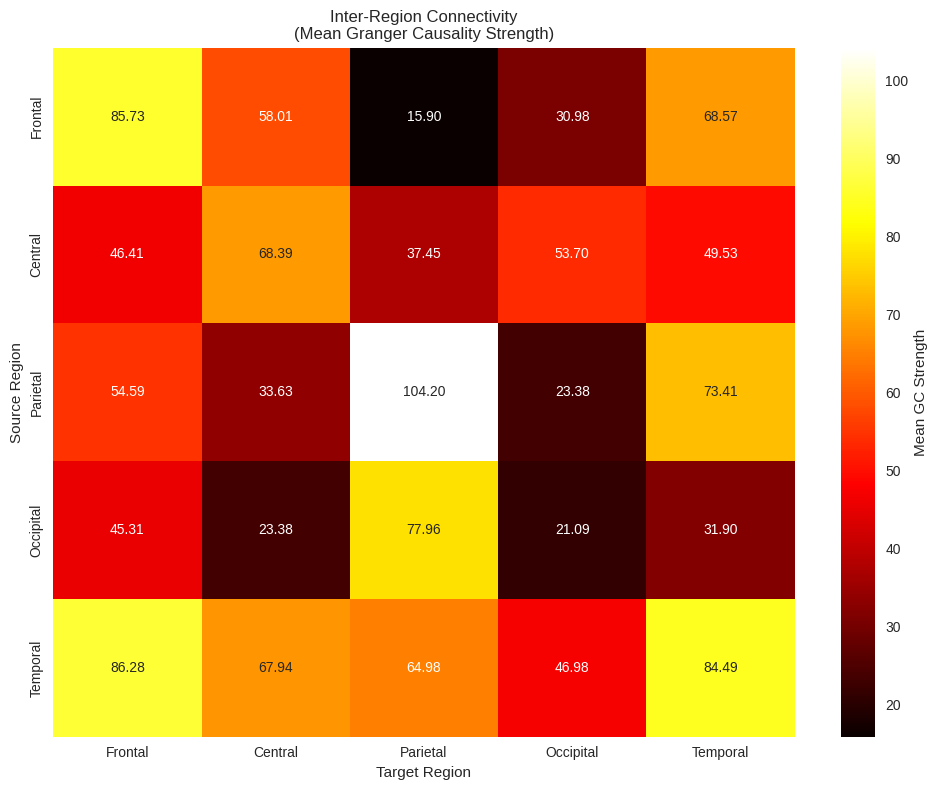


=== BRAIN REGION CONNECTIVITY SUMMARY ===
Frontal → Frontal: 85.732 (n=42)
Frontal → Central: 58.012 (n=20)
Frontal → Parietal: 15.902 (n=20)
Frontal → Occipital: 30.982 (n=14)
Frontal → Temporal: 68.567 (n=28)
Central → Frontal: 46.415 (n=20)
Central → Central: 68.390 (n=6)
Central → Parietal: 37.452 (n=9)
Central → Occipital: 53.698 (n=6)
Central → Temporal: 49.528 (n=12)
Parietal → Frontal: 54.589 (n=21)
Parietal → Central: 33.626 (n=9)
Parietal → Parietal: 104.204 (n=6)
Parietal → Occipital: 23.384 (n=6)
Parietal → Temporal: 73.414 (n=12)
Occipital → Frontal: 45.311 (n=14)
Occipital → Central: 23.380 (n=6)
Occipital → Parietal: 77.964 (n=5)
Occipital → Occipital: 21.088 (n=1)
Occipital → Temporal: 31.901 (n=8)
Temporal → Frontal: 86.285 (n=28)
Temporal → Central: 67.940 (n=12)
Temporal → Parietal: 64.979 (n=12)
Temporal → Occipital: 46.981 (n=8)
Temporal → Temporal: 84.492 (n=12)


In [138]:
def analyze_brain_regions(gc_matrix, p_values, channel_names, alpha=0.05, save_path=None):
    """
    Analyze connectivity patterns by brain regions
    """
    # Define brain regions based on electrode names
    regions = {
        'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ'],
        'Central': ['C3', 'C4', 'CZ'],
        'Parietal': ['P3', 'P4', 'PZ'],
        'Occipital': ['O1', 'O2'],
        'Temporal': ['T3', 'T4', 'T5', 'T6']
    }
    
    # Create region mapping
    channel_to_region = {}
    for region, channels in regions.items():
        for ch in channels:
            if ch in channel_names:
                channel_to_region[ch] = region
    
    # Calculate inter-region connectivity
    region_connectivity = {}
    for source_region in regions.keys():
        region_connectivity[source_region] = {}
        for target_region in regions.keys():
            connections = []
            
            for source_ch in channel_names:
                for target_ch in channel_names:
                    if (source_ch in channel_to_region and 
                        target_ch in channel_to_region and
                        channel_to_region[source_ch] == source_region and
                        channel_to_region[target_ch] == target_region and
                        source_ch != target_ch):
                        
                        i = channel_names.index(source_ch)
                        j = channel_names.index(target_ch)
                        
                        if p_values[i, j] < alpha:
                            connections.append(gc_matrix[i, j])
            
            region_connectivity[source_region][target_region] = {
                'mean_strength': np.mean(connections) if connections else 0,
                'num_connections': len(connections)
            }
    
    # Create region connectivity matrix
    region_names = list(regions.keys())
    region_matrix = np.zeros((len(region_names), len(region_names)))
    
    for i, source in enumerate(region_names):
        for j, target in enumerate(region_names):
            region_matrix[i, j] = region_connectivity[source][target]['mean_strength']
    
    # Plot region connectivity
    plt.figure(figsize=(10, 8))
    sns.heatmap(region_matrix, 
                xticklabels=region_names, 
                yticklabels=region_names,
                annot=True, 
                fmt='.2f', 
                cmap='hot',
                cbar_kws={'label': 'Mean GC Strength'})
    
    plt.title('Inter-Region Connectivity\n(Mean Granger Causality Strength)')
    plt.xlabel('Target Region')
    plt.ylabel('Source Region')
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print region summary
    print("\n=== BRAIN REGION CONNECTIVITY SUMMARY ===")
    for source in region_names:
        for target in region_names:
            strength = region_connectivity[source][target]['mean_strength']
            count = region_connectivity[source][target]['num_connections']
            if strength > 0:
                print(f"{source} → {target}: {strength:.3f} (n={count})")
    
    return region_connectivity, region_matrix

# Analyze brain regions
region_conn, region_matrix = analyze_brain_regions(
    gc_matrix, p_values, channel_names, 
    save_path=os.path.join(output_dir, 'brain_region_connectivity.png')
)

## 5. Interpretation

This analysis provides insights into the causal relationships between different brain regions in infant EEG data:

### Key Findings:
1. **Network Topology**: The connectivity patterns reveal the functional network organization
2. **Regional Interactions**: Different brain regions show varying levels of causal influence
3. **Developmental Insights**: These patterns may reflect the developmental state of neural circuits

### Next Steps:
- Compare across different time windows
- Analyze frequency-specific connectivity
- Compare with adult patterns
- Correlate with behavioral measures

### References:
- Granger, C. W. J. (1969). Investigating causal relations by econometric models
- Seth, A. K. (2010). A MATLAB toolbox for Granger causal connectivity analysis

In [139]:
import os
import numpy as np

# Assuming other parts of the code define these variables
# output_dir = "path_to_subject_specific_directory"
# gc_matrix, p_values, significant_gc, channel_names, connections_df, node_stats

# Save results to files
print("Saving results...")

# Save connectivity matrices to subject-specific directory
np.save(os.path.join(output_dir, 'gc_matrix.npy'), gc_matrix)
np.save(os.path.join(output_dir, 'p_values.npy'), p_values)
np.save(os.path.join(output_dir, 'significant_gc.npy'), significant_gc)

# Save channel names
with open(os.path.join(output_dir, 'channel_names.txt'), 'w') as f:
    for ch in channel_names:
        f.write(f"{ch}\n")

# Save statistics
if connections_df is not None:
    connections_df.to_csv(os.path.join(output_dir, 'significant_connections.csv'), index=False)
node_stats.to_csv(os.path.join(output_dir, 'node_statistics.csv'), index=False)

print("Results saved successfully!")
print(f"\nFiles saved to: {output_dir}")
print("- gc_matrix.npy: Full Granger causality matrix")
print("- p_values.npy: Statistical significance values")
print("- significant_gc.npy: Thresholded significant connections")
print("- significant_connections.csv: List of significant connections")
print("- node_statistics.csv: Node-wise connectivity statistics")
print("- channel_names.txt: EEG channel names")

Saving results...
Results saved successfully!

Files saved to: ./Dataset/Infants_data_output/NORB00064_ses3
- gc_matrix.npy: Full Granger causality matrix
- p_values.npy: Statistical significance values
- significant_gc.npy: Thresholded significant connections
- significant_connections.csv: List of significant connections
- node_statistics.csv: Node-wise connectivity statistics
- channel_names.txt: EEG channel names


## 6. Time Window Comparison Analysis

This section analyzes how Granger causality patterns change across different time windows within the same recording. This can reveal:
- Temporal stability of connectivity patterns
- Dynamic changes in brain network organization
- Developmental fluctuations in neural interactions

In [140]:
def segment_data_into_windows(data, window_length_sec, overlap_ratio=0.5, sampling_freq=100):
    """
    Segment EEG data into overlapping time windows
    
    Parameters:
    -----------
    data : numpy array
        EEG data (channels x time)
    window_length_sec : float
        Length of each window in seconds
    overlap_ratio : float
        Overlap between windows (0.5 = 50% overlap)
    sampling_freq : float
        Sampling frequency in Hz
    
    Returns:
    --------
    windows : list
        List of data windows
    window_info : list
        Information about each window (start_time, end_time)
    """
    window_samples = int(window_length_sec * sampling_freq)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    windows = []
    window_info = []
    
    start_idx = 0
    while start_idx + window_samples <= data.shape[1]:
        end_idx = start_idx + window_samples
        
        # Extract window
        window_data = data[:, start_idx:end_idx]
        windows.append(window_data)
        
        # Store window info
        start_time = start_idx / sampling_freq
        end_time = end_idx / sampling_freq
        window_info.append({
            'window_idx': len(windows) - 1,
            'start_time': start_time,
            'end_time': end_time,
            'duration': end_time - start_time
        })
        
        start_idx += step_samples
    
    print(f"Created {len(windows)} windows of {window_length_sec}s each")
    print(f"Window overlap: {overlap_ratio*100:.0f}%")
    
    return windows, window_info

# Test with different window sizes
window_sizes = [2, 4, 6]  # seconds - modified for 2-second analysis
print("Available data duration:", eeg_subset.shape[1] / new_fs, "seconds")
print("Testing window sizes:", window_sizes, "seconds")

Available data duration: 320.0 seconds
Testing window sizes: [2, 4, 6] seconds


In [141]:
def calculate_gc_across_windows(data, channel_names, window_length_sec, 
                                overlap_ratio=0.5, sampling_freq=100, max_lag=3):
    """
    Calculate Granger causality across multiple time windows
    """
    # Segment data
    windows, window_info = segment_data_into_windows(
        data, window_length_sec, overlap_ratio, sampling_freq
    )
    
    n_channels = len(channel_names)
    n_windows = len(windows)
    
    # Store results for each window
    gc_results = {
        'gc_matrices': [],
        'p_value_matrices': [],
        'significant_matrices': [],
        'window_info': window_info
    }
    
    print(f"\nCalculating GC for {n_windows} windows...")
    
    for i, window_data in enumerate(windows):
        print(f"Processing window {i+1}/{n_windows} ", end="")
        
        try:
            # Calculate GC for this window
            gc_matrix, p_values = calculate_granger_causality(
                window_data, channel_names, max_lag=max_lag, alpha=0.05
            )
            
            # Apply significance threshold
            significant_gc = apply_significance_threshold(gc_matrix, p_values, alpha=0.05)
            
            gc_results['gc_matrices'].append(gc_matrix)
            gc_results['p_value_matrices'].append(p_values)
            gc_results['significant_matrices'].append(significant_gc)
            
            print(f"✓ ({np.sum(significant_gc > 0)} significant connections)")
            
        except Exception as e:
            print(f"✗ Error: {e}")
            # Add empty matrices for failed windows
            gc_results['gc_matrices'].append(np.zeros((n_channels, n_channels)))
            gc_results['p_value_matrices'].append(np.ones((n_channels, n_channels)))
            gc_results['significant_matrices'].append(np.zeros((n_channels, n_channels)))
    
    return gc_results

# Calculate GC for 2-second windows
print("\n=== ANALYZING 2-SECOND WINDOWS ===")
gc_windows_t_seconds = calculate_gc_across_windows(
    eeg_subset, channel_names, 
    window_length_sec=2, 
    overlap_ratio=0.3,  # 30% overlap
    sampling_freq=new_fs,
    max_lag=3
)


=== ANALYZING 2-SECOND WINDOWS ===
Created 228 windows of 2s each
Window overlap: 30%

Calculating GC for 228 windows...
Processing window 1/228 Calculating Granger causality for 19 channels...
✓ (222 significant connections)
Processing window 2/228 Calculating Granger causality for 19 channels...
✓ (155 significant connections)
Processing window 3/228 Calculating Granger causality for 19 channels...
✓ (171 significant connections)
Processing window 4/228 Calculating Granger causality for 19 channels...
✓ (195 significant connections)
Processing window 5/228 Calculating Granger causality for 19 channels...
✓ (222 significant connections)
Processing window 6/228 Calculating Granger causality for 19 channels...
✓ (264 significant connections)
Processing window 7/228 Calculating Granger causality for 19 channels...
✓ (108 significant connections)
Processing window 8/228 Calculating Granger causality for 19 channels...
✓ (166 significant connections)
Processing window 9/228 Calculating Gr

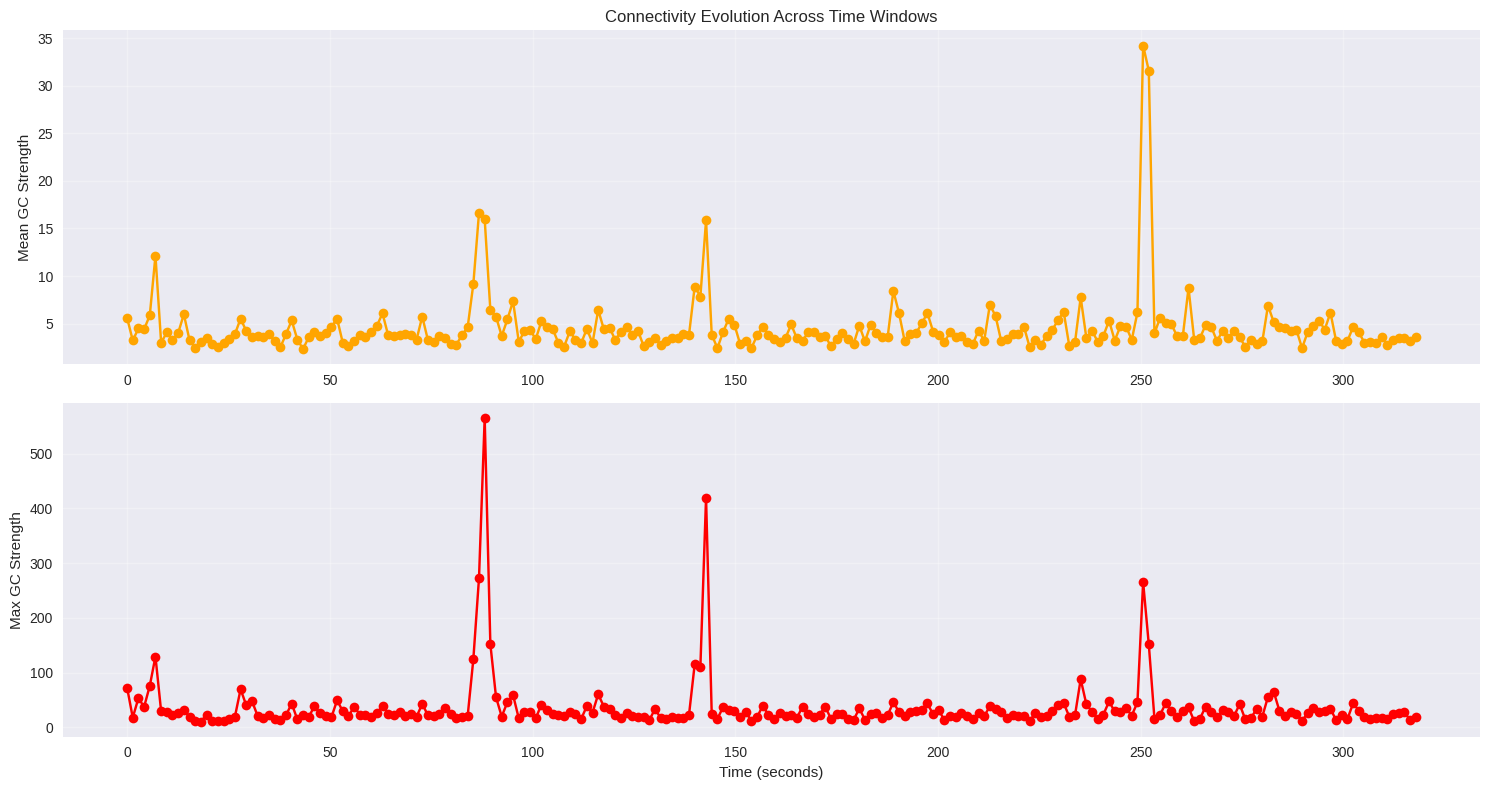

In [142]:
def plot_connectivity_evolution(gc_results, channel_names, connection_threshold_percentile=80, save_path=None):
    """
    Plot how connectivity evolves across time windows
    """
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    n_windows = len(gc_matrices)
    n_channels = len(channel_names)
    
    # Calculate global connectivity metrics for each window
    connectivity_metrics = []
    
    for i, gc_matrix in enumerate(gc_matrices):
        # Calculate metrics
        total_connections = np.sum(gc_matrix > 0)
        mean_strength = np.mean(gc_matrix[gc_matrix > 0]) if total_connections > 0 else 0
        max_strength = np.max(gc_matrix)
        
        connectivity_metrics.append({
            'window': i,
            'start_time': window_info[i]['start_time'],
            'end_time': window_info[i]['end_time'],
            'total_connections': total_connections,
            'mean_strength': mean_strength,
            'max_strength': max_strength
        })
    
    metrics_df = pd.DataFrame(connectivity_metrics)
    
    # Plot connectivity metrics over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Mean strength
    axes[0].set_title('Connectivity Evolution Across Time Windows')
    axes[0].plot(metrics_df['start_time'], metrics_df['mean_strength'], 'o-', color='orange')
    axes[0].set_ylabel('Mean GC Strength')
    axes[0].grid(True, alpha=0.3)
    
    # Max strength
    axes[1].plot(metrics_df['start_time'], metrics_df['max_strength'], 'o-', color='red')
    axes[1].set_ylabel('Max GC Strength')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return metrics_df

# Plot connectivity evolution
metrics_df = plot_connectivity_evolution(
    gc_windows_t_seconds, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_evolution.png')
)

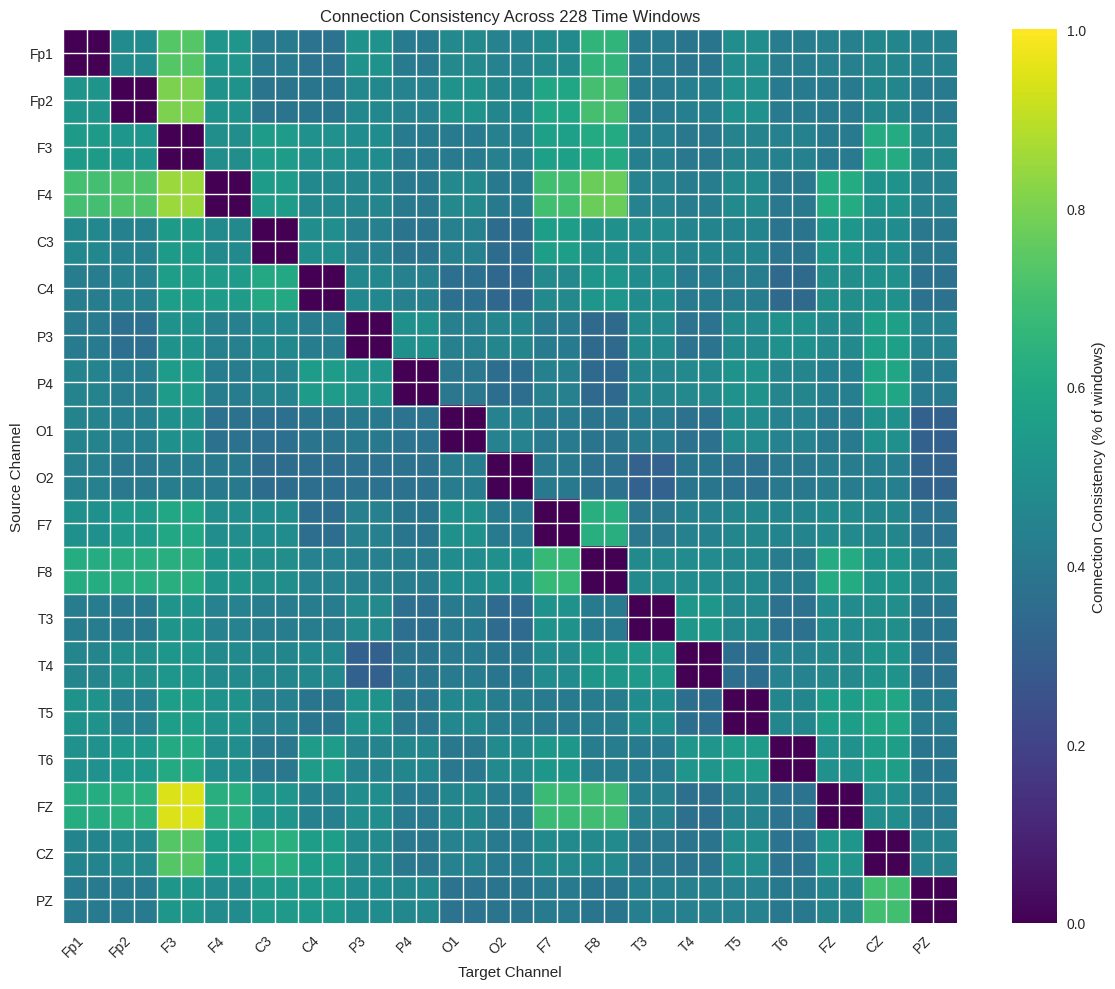


=== MOST STABLE CONNECTIONS ===
   source target  consistency
74     FZ     F3     0.947368
20     F4     F3     0.850877
5     Fp2     F3     0.802632
23     F4     F8     0.776316
79     CZ     F3     0.736842
0     Fp1     F3     0.736842
19     F4    Fp2     0.723684
9     Fp2     F8     0.706140
18     F4    Fp1     0.701754
87     PZ     CZ     0.697368
22     F4     F7     0.697368
78     FZ     F8     0.692982
77     FZ     F7     0.679825
47     F8     F7     0.671053
3     Fp1     F8     0.653509


In [143]:
def analyze_connectivity_stability(gc_results, channel_names, save_path=None):
    """
    Analyze stability of connectivity patterns across time windows
    """
    significant_matrices = gc_results['significant_matrices']
    n_windows = len(significant_matrices)
    n_channels = len(channel_names)
    
    # Calculate connection consistency across windows
    connection_consistency = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                # Count how many windows show this connection
                connection_count = sum(1 for matrix in significant_matrices 
                                     if matrix[i, j] > 0)
                connection_consistency[i, j] = connection_count / n_windows
    
    # Plot connection consistency
    plt.figure(figsize=(12, 10))
    im = plt.imshow(connection_consistency, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    
    plt.xticks(range(len(channel_names)), channel_names, rotation=45, ha='right')
    plt.yticks(range(len(channel_names)), channel_names)
    
    cbar = plt.colorbar(im)
    cbar.set_label('Connection Consistency (% of windows)')
    
    plt.xlabel('Target Channel')
    plt.ylabel('Source Channel')
    plt.title(f'Connection Consistency Across {n_windows} Time Windows')
    
    # Add grid
    plt.xticks(np.arange(len(channel_names)) - 0.5, minor=True)
    plt.yticks(np.arange(len(channel_names)) - 0.5, minor=True)
    plt.grid(which="minor", color="w", linestyle='-', linewidth=1)
    
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Find most stable connections
    stable_connections = []
    stable_df = None
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j and connection_consistency[i, j] > 0.5:  # Present in >50% of windows
                stable_connections.append({
                    'source': channel_names[i],
                    'target': channel_names[j],
                    'consistency': connection_consistency[i, j]
                })
    
    if stable_connections:
        stable_df = pd.DataFrame(stable_connections)
        stable_df = stable_df.sort_values('consistency', ascending=False)
        
        print("\n=== MOST STABLE CONNECTIONS ===")
        print(stable_df.head(15))
    else:
        print("\nNo highly stable connections found (>50% consistency)")
    
    return connection_consistency, stable_df if stable_connections else None

# Analyze connectivity stability
consistency_matrix, stable_connections = analyze_connectivity_stability(
    gc_windows_t_seconds, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_stability.png')
)


=== CONNECTION FREQUENCY ANALYSIS ===


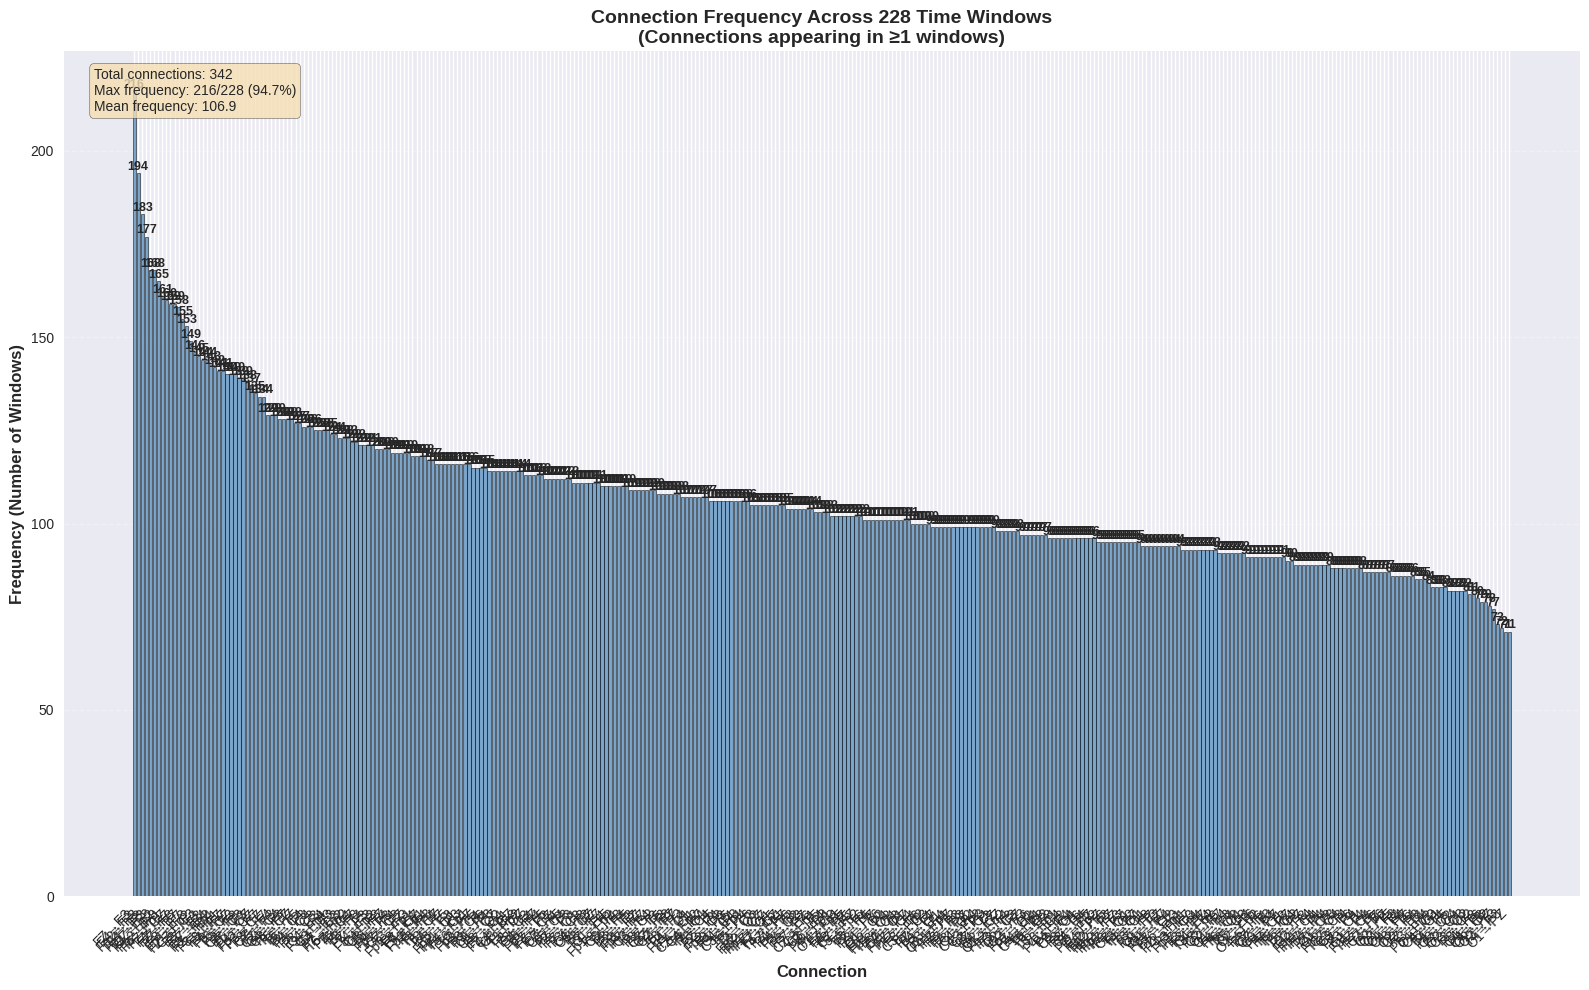


=== TOP 10 MOST FREQUENT CONNECTIONS ===
 1. FZ→F3           : 216/228 windows ( 94.7%)
 2. F4→F3           : 194/228 windows ( 85.1%)
 3. Fp2→F3          : 183/228 windows ( 80.3%)
 4. F4→F8           : 177/228 windows ( 77.6%)
 5. Fp1→F3          : 168/228 windows ( 73.7%)
 6. CZ→F3           : 168/228 windows ( 73.7%)
 7. F4→Fp2          : 165/228 windows ( 72.4%)
 8. Fp2→F8          : 161/228 windows ( 70.6%)
 9. F4→Fp1          : 160/228 windows ( 70.2%)
10. PZ→CZ           : 159/228 windows ( 69.7%)
Found 342 connections meeting the criteria


In [144]:
def plot_connection_frequency(gc_results, channel_names, min_frequency=1, save_path=None):
    """
    Plot frequency of appearance of connections vs connection names
    
    Parameters:
    -----------
    gc_results : dict
        Results from calculate_gc_across_windows containing significant_matrices
    channel_names : list
        Names of EEG channels
    min_frequency : int
        Minimum frequency to include in plot (default: 1)
    save_path : str
        Path to save the plot
    """
    significant_matrices = gc_results['significant_matrices']
    n_windows = len(significant_matrices)
    n_channels = len(channel_names)
    
    # Count frequency for each connection
    connection_frequencies = []
    connection_names = []
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:  # Skip self-connections
                # Count how many windows show this connection
                connection_count = sum(1 for matrix in significant_matrices 
                                     if matrix[i, j] > 0)
                
                if connection_count >= min_frequency:
                    connection_frequencies.append(connection_count)
                    connection_names.append(f"{channel_names[i]}→{channel_names[j]}")
    
    # Sort by frequency (descending)
    sorted_data = sorted(zip(connection_frequencies, connection_names), reverse=True)
    frequencies, names = zip(*sorted_data) if sorted_data else ([], [])
    
    if not frequencies:
        print(f"No connections found with frequency >= {min_frequency}")
        return None
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Create bar plot
    bars = plt.bar(range(len(frequencies)), frequencies, alpha=0.7, 
                   color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Customize the plot
    plt.xlabel('Connection', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency (Number of Windows)', fontsize=12, fontweight='bold')
    plt.title(f'Connection Frequency Across {n_windows} Time Windows\n'
              f'(Connections appearing in ≥{min_frequency} windows)', 
              fontsize=14, fontweight='bold')
    
    # Set x-axis labels
    plt.xticks(range(len(names)), names, rotation=45, ha='right', fontsize=10)
    
    # Add value labels on top of bars
    for i, (bar, freq) in enumerate(zip(bars, frequencies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(freq), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Adjust layout
    plt.tight_layout()
    
    # Add summary statistics as text
    total_connections = len(frequencies)
    max_freq = max(frequencies)
    mean_freq = np.mean(frequencies)
    
    stats_text = f'Total connections: {total_connections}\n'
    stats_text += f'Max frequency: {max_freq}/{n_windows} ({max_freq/n_windows*100:.1f}%)\n'
    stats_text += f'Mean frequency: {mean_freq:.1f}'
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=10)
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print top connections
    print(f"\n=== TOP 10 MOST FREQUENT CONNECTIONS ===")
    for i, (freq, name) in enumerate(zip(frequencies[:10], names[:10])):
        percentage = freq/n_windows*100
        print(f"{i+1:2d}. {name:<15} : {freq:2d}/{n_windows} windows ({percentage:5.1f}%)")
    
    return frequencies, names

# Generate connection frequency plot
if 'gc_windows_t_seconds' in locals():
    print("\n=== CONNECTION FREQUENCY ANALYSIS ===")
    result = plot_connection_frequency(
        gc_windows_t_seconds, channel_names,
        min_frequency=1,  # Show all connections that appear at least once
        save_path=os.path.join(output_dir, 'connection_frequency.png')
    )
    
    # Handle the case where no connections are found
    if result is not None:
        frequencies, connection_names_list = result
        print(f"Found {len(frequencies)} connections meeting the criteria")
    else:
        print("No connections found meeting the minimum frequency requirement")
        frequencies, connection_names_list = [], []

In [145]:
def compare_window_sizes(data, channel_names, window_sizes, sampling_freq):
    """
    Compare connectivity patterns across different window sizes
    """
    results_by_size = {}
    
    for window_size in window_sizes:
        print(f"\n=== ANALYZING {window_size}-SECOND WINDOWS ===")
        
        gc_results = calculate_gc_across_windows(
            data, channel_names,
            window_length_sec=window_size,
            overlap_ratio=0.3,  # Reduced overlap for different sizes
            sampling_freq=sampling_freq,
            max_lag=3
        )
        
        results_by_size[window_size] = gc_results
    
    return results_by_size

# Compare different window sizes (if we have enough data)
available_duration = eeg_subset.shape[1] / new_fs
print(f"Available data duration: {available_duration:.1f} seconds")

# Select appropriate window sizes based on available data
if available_duration > 12:  # More than 12 seconds (enough for 6 2-second windows)
    test_window_sizes = [2, 4, 6]
else:
    test_window_sizes = [2, 4] if available_duration > 8 else [2]

print(f"Testing window sizes: {test_window_sizes} seconds")

# Only run if we have sufficient data
if available_duration > min(test_window_sizes) * 3:  # Need at least 3 windows
    window_comparison = compare_window_sizes(
        eeg_subset, channel_names, test_window_sizes, new_fs
    )
else:
    print("Insufficient data for multiple window size comparison")
    window_comparison = None

Available data duration: 320.0 seconds
Testing window sizes: [2, 4, 6] seconds

=== ANALYZING 2-SECOND WINDOWS ===
Created 228 windows of 2s each
Window overlap: 30%

Calculating GC for 228 windows...
Processing window 1/228 Calculating Granger causality for 19 channels...
✓ (222 significant connections)
Processing window 2/228 Calculating Granger causality for 19 channels...
✓ (155 significant connections)
Processing window 3/228 Calculating Granger causality for 19 channels...
✓ (171 significant connections)
Processing window 4/228 Calculating Granger causality for 19 channels...
✓ (195 significant connections)
Processing window 5/228 Calculating Granger causality for 19 channels...
✓ (222 significant connections)
Processing window 6/228 Calculating Granger causality for 19 channels...
✓ (264 significant connections)
Processing window 7/228 Calculating Granger causality for 19 channels...
✓ (108 significant connections)
Processing window 8/228 Calculating Granger causality for 19 cha

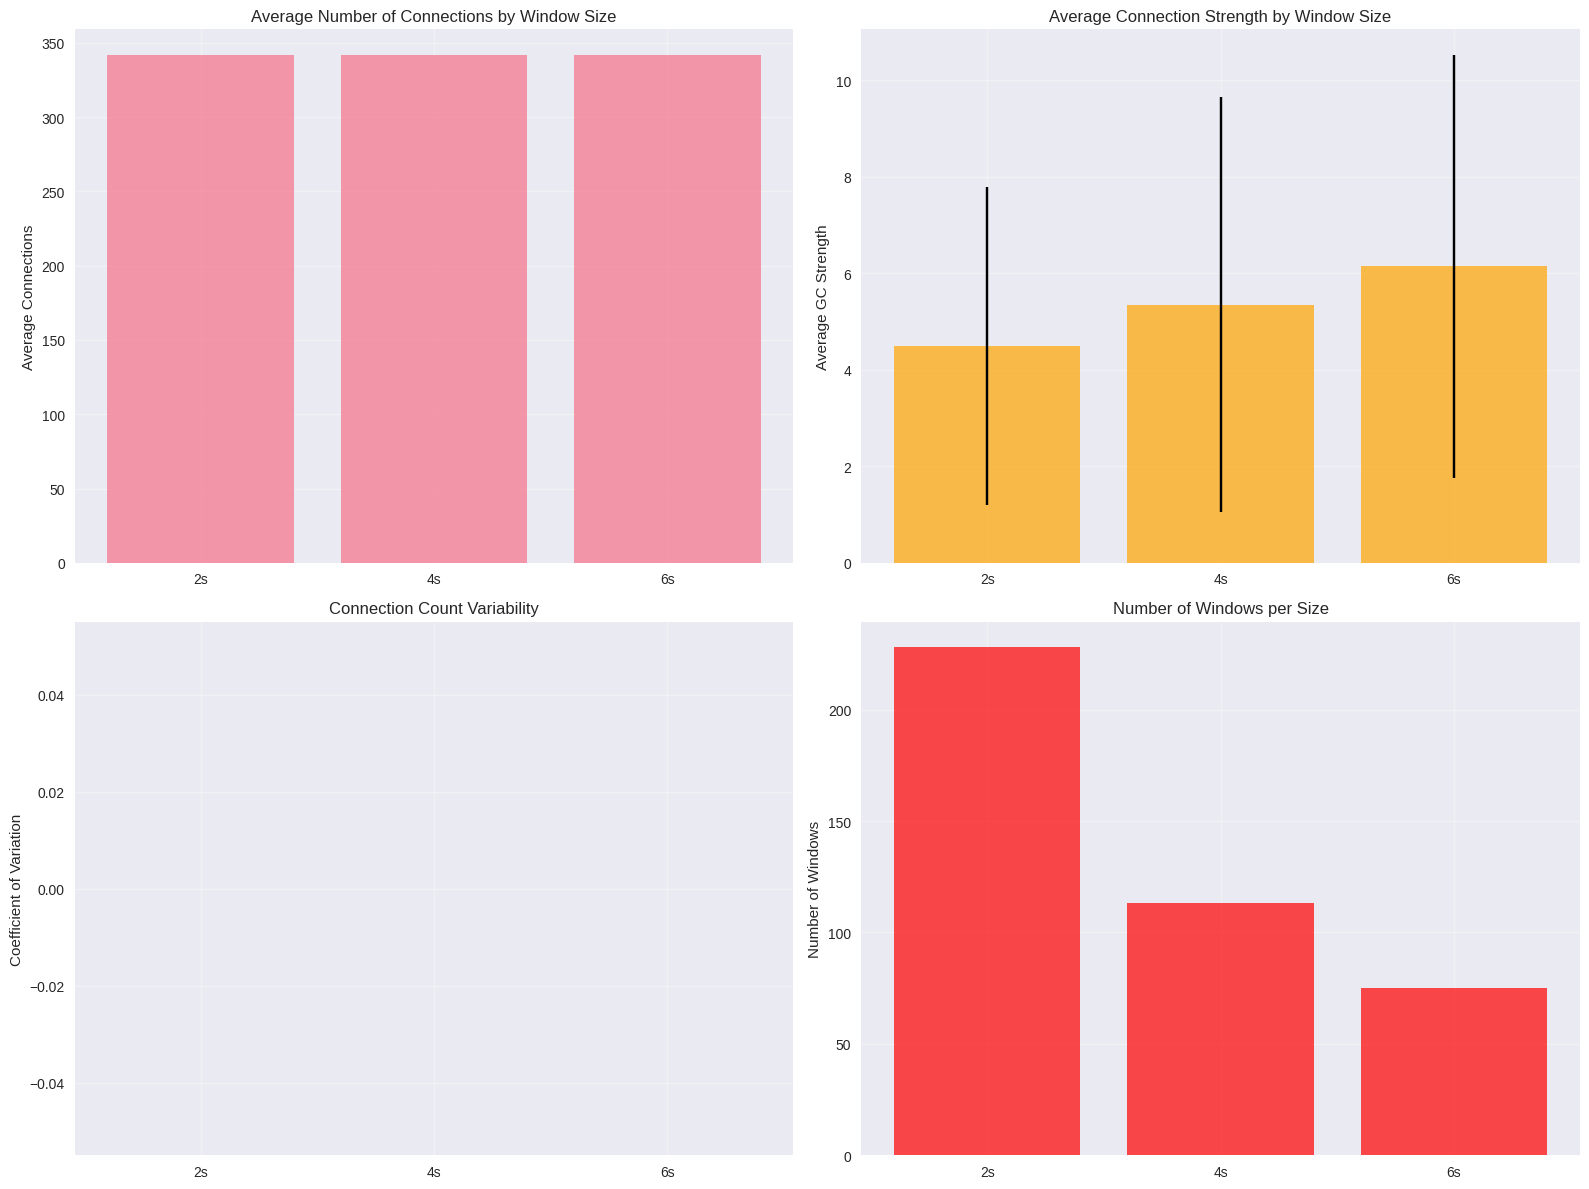


=== WINDOW SIZE COMPARISON SUMMARY ===

2-second windows:
  Number of windows: 228
  Avg connections: 342.0 ± 0.0
  Avg GC strength: 4.496 ± 3.292
  Variability (CV): 0.000

4-second windows:
  Number of windows: 113
  Avg connections: 342.0 ± 0.0
  Avg GC strength: 5.347 ± 4.303
  Variability (CV): 0.000

6-second windows:
  Number of windows: 75
  Avg connections: 342.0 ± 0.0
  Avg GC strength: 6.142 ± 4.382
  Variability (CV): 0.000


In [146]:
def plot_window_size_comparison(window_comparison, channel_names, save_path=None):
    """
    Plot comparison of connectivity metrics across different window sizes
    """
    if window_comparison is None:
        print("No window comparison data available")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    window_sizes = list(window_comparison.keys())
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(window_sizes)))
    
    # Collect metrics for each window size
    all_metrics = {}
    
    for size in window_sizes:
        gc_results = window_comparison[size]
        metrics = []
        
        for i, gc_matrix in enumerate(gc_results['gc_matrices']):
            total_conn = np.sum(gc_matrix > 0)
            mean_strength = np.mean(gc_matrix[gc_matrix > 0]) if total_conn > 0 else 0
            
            metrics.append({
                'total_connections': total_conn,
                'mean_strength': mean_strength,
                'window_idx': i
            })
        
        all_metrics[size] = pd.DataFrame(metrics)
    
    # Plot 1: Average number of connections per window size
    avg_connections = [all_metrics[size]['total_connections'].mean() for size in window_sizes]
    std_connections = [all_metrics[size]['total_connections'].std() for size in window_sizes]
    
    axes[0,0].bar(range(len(window_sizes)), avg_connections, 
                  yerr=std_connections, capsize=5, alpha=0.7)
    axes[0,0].set_xticks(range(len(window_sizes)))
    axes[0,0].set_xticklabels([f'{size}s' for size in window_sizes])
    axes[0,0].set_ylabel('Average Connections')
    axes[0,0].set_title('Average Number of Connections by Window Size')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Average connection strength per window size
    avg_strength = [all_metrics[size]['mean_strength'].mean() for size in window_sizes]
    std_strength = [all_metrics[size]['mean_strength'].std() for size in window_sizes]
    
    axes[0,1].bar(range(len(window_sizes)), avg_strength, 
                  yerr=std_strength, capsize=5, alpha=0.7, color='orange')
    axes[0,1].set_xticks(range(len(window_sizes)))
    axes[0,1].set_xticklabels([f'{size}s' for size in window_sizes])
    axes[0,1].set_ylabel('Average GC Strength')
    axes[0,1].set_title('Average Connection Strength by Window Size')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Connection variability across windows
    variability = [all_metrics[size]['total_connections'].std() / 
                   all_metrics[size]['total_connections'].mean() 
                   for size in window_sizes]
    
    axes[1,0].bar(range(len(window_sizes)), variability, alpha=0.7, color='green')
    axes[1,0].set_xticks(range(len(window_sizes)))
    axes[1,0].set_xticklabels([f'{size}s' for size in window_sizes])
    axes[1,0].set_ylabel('Coefficient of Variation')
    axes[1,0].set_title('Connection Count Variability')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Number of windows per size
    n_windows = [len(all_metrics[size]) for size in window_sizes]
    
    axes[1,1].bar(range(len(window_sizes)), n_windows, alpha=0.7, color='red')
    axes[1,1].set_xticks(range(len(window_sizes)))
    axes[1,1].set_xticklabels([f'{size}s' for size in window_sizes])
    axes[1,1].set_ylabel('Number of Windows')
    axes[1,1].set_title('Number of Windows per Size')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Summary statistics
    print("\n=== WINDOW SIZE COMPARISON SUMMARY ===")
    for size in window_sizes:
        metrics = all_metrics[size]
        print(f"\n{size}-second windows:")
        print(f"  Number of windows: {len(metrics)}")
        print(f"  Avg connections: {metrics['total_connections'].mean():.1f} ± {metrics['total_connections'].std():.1f}")
        print(f"  Avg GC strength: {metrics['mean_strength'].mean():.3f} ± {metrics['mean_strength'].std():.3f}")
        print(f"  Variability (CV): {metrics['total_connections'].std()/metrics['total_connections'].mean():.3f}")

# Plot window size comparison
if window_comparison:
    plot_window_size_comparison(
        window_comparison, channel_names,
        save_path=os.path.join(output_dir, 'window_size_comparison.png')
    )


=== TEMPORAL DYNAMICS ANALYSIS ===


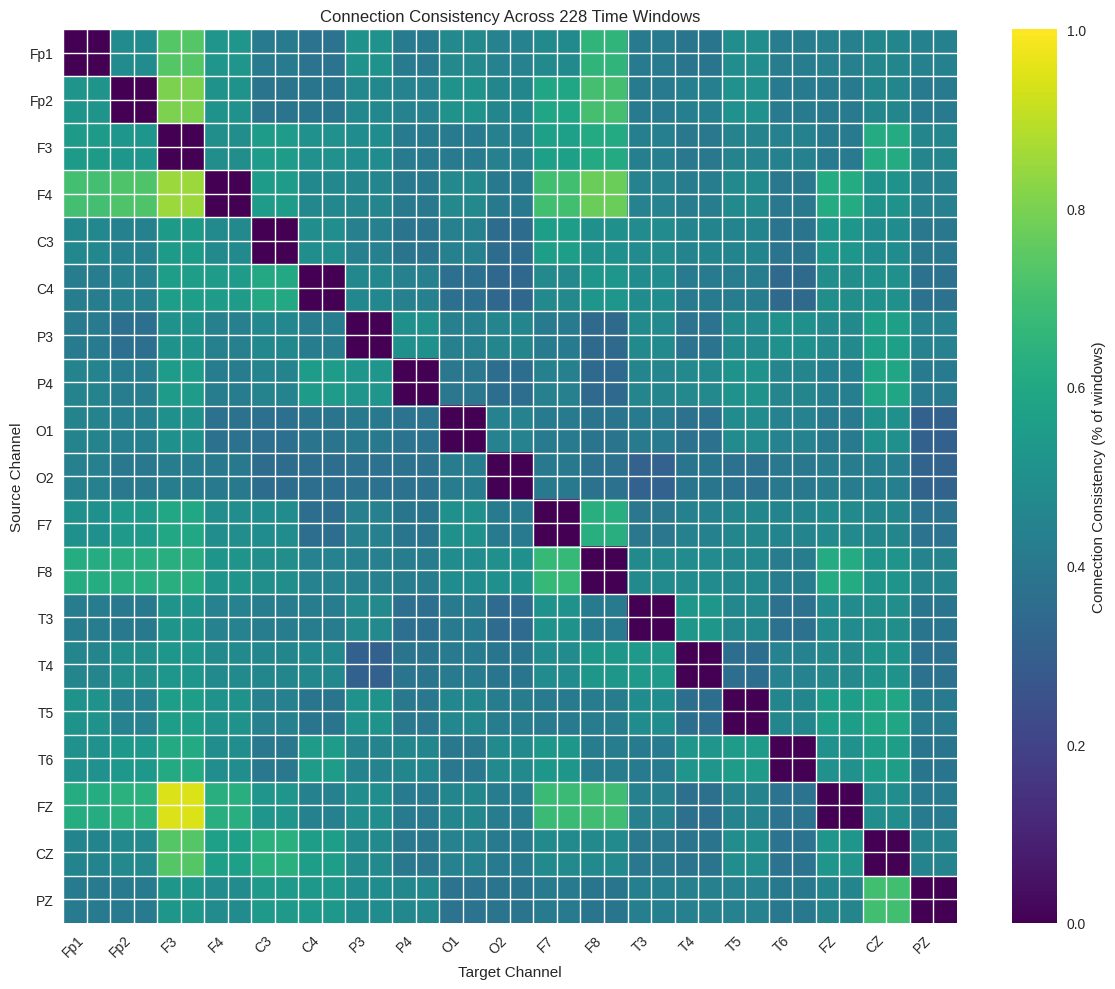


=== MOST STABLE CONNECTIONS ===
   source target  consistency
74     FZ     F3     0.947368
20     F4     F3     0.850877
5     Fp2     F3     0.802632
23     F4     F8     0.776316
79     CZ     F3     0.736842
0     Fp1     F3     0.736842
19     F4    Fp2     0.723684
9     Fp2     F8     0.706140
18     F4    Fp1     0.701754
87     PZ     CZ     0.697368
22     F4     F7     0.697368
78     FZ     F8     0.692982
77     FZ     F7     0.679825
47     F8     F7     0.671053
3     Fp1     F8     0.653509


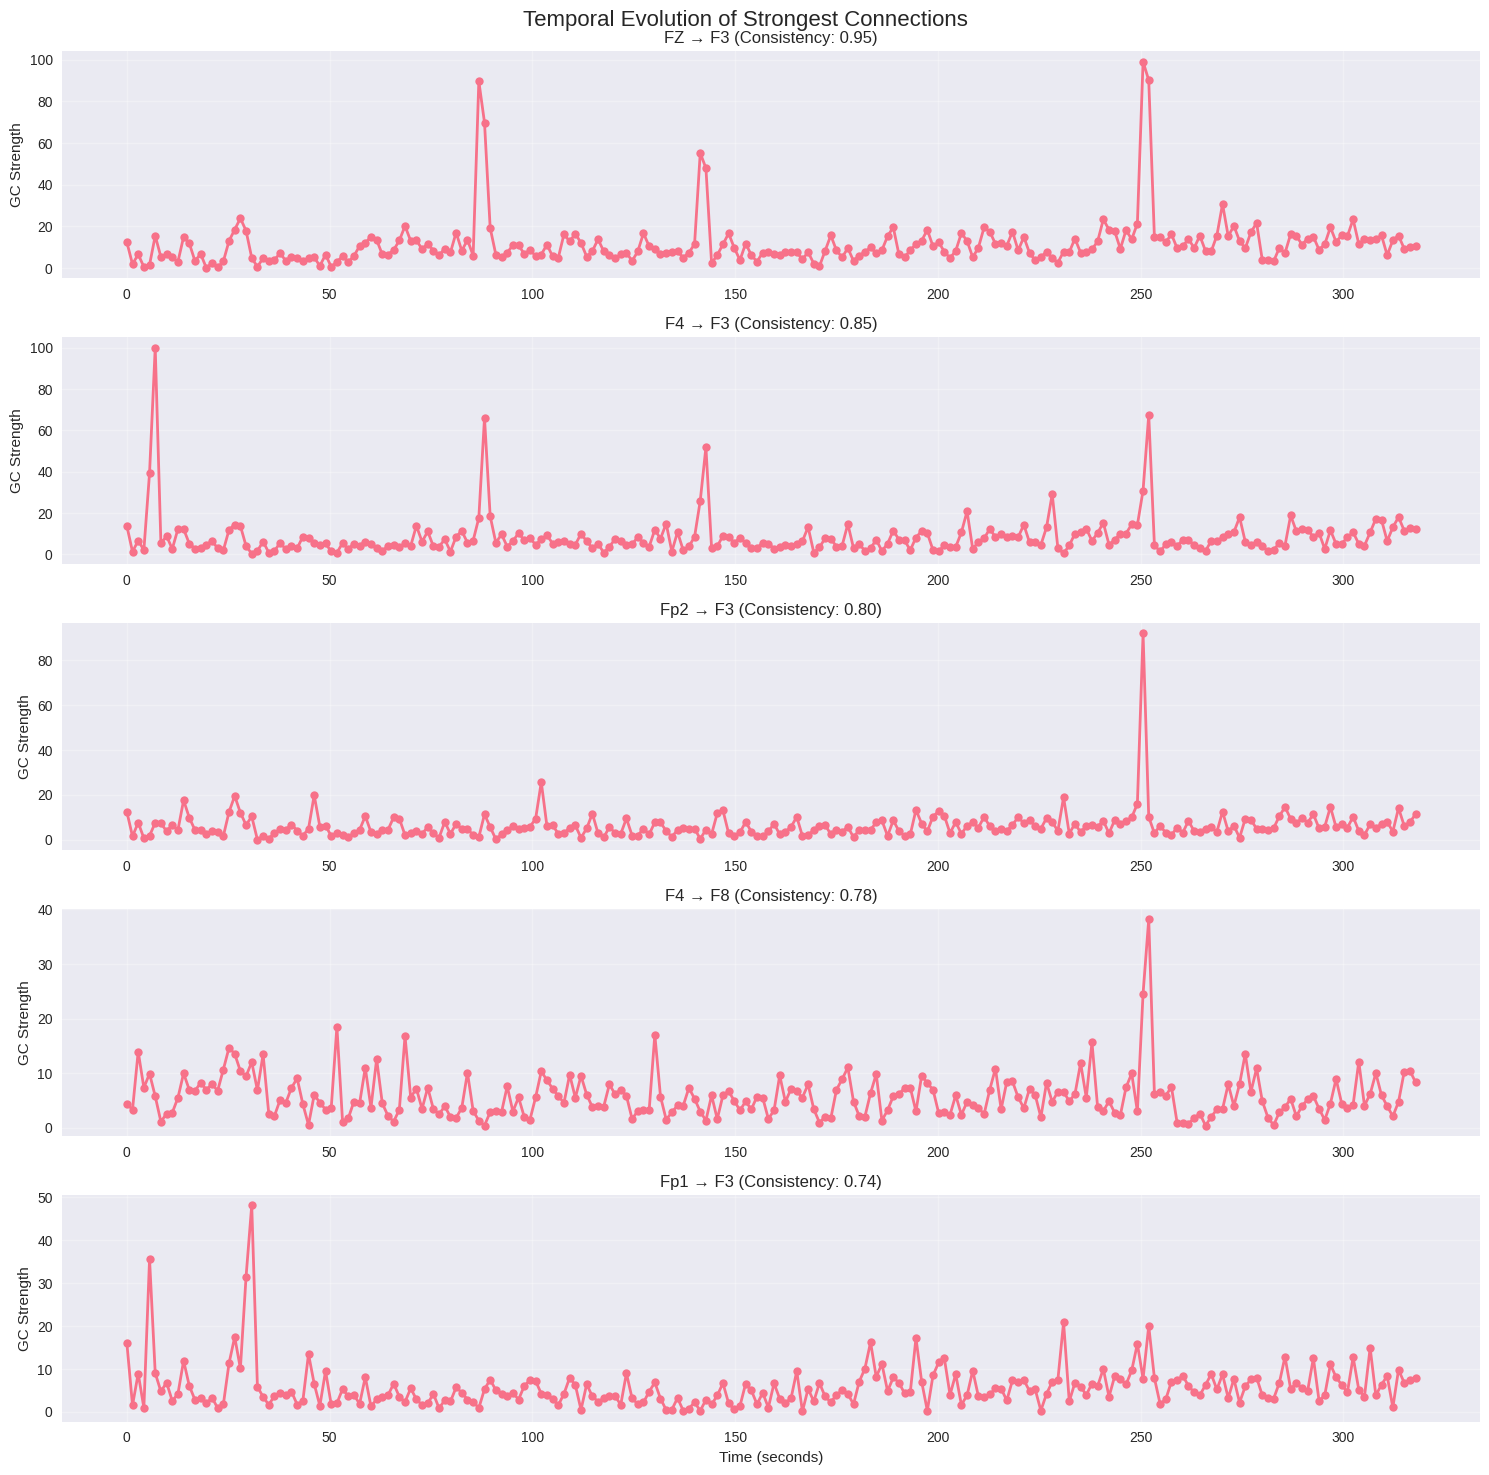

In [147]:
def analyze_temporal_dynamics(gc_results, channel_names, selected_pairs=None, save_path=None):
    """
    Analyze temporal dynamics of specific channel pairs
    """
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    n_windows = len(gc_matrices)
    
    if selected_pairs is None:
        # Select most consistently connected pairs
        consistency_matrix, _ = analyze_connectivity_stability(gc_results, channel_names)
        
        # Find top 5 most consistent connections
        selected_pairs = []
        for i in range(len(channel_names)):
            for j in range(len(channel_names)):
                if i != j and consistency_matrix[i, j] > 0.3:  # At least 30% consistency
                    selected_pairs.append((i, j, consistency_matrix[i, j]))
        
        # Sort by consistency and take top 5
        selected_pairs.sort(key=lambda x: x[2], reverse=True)
        selected_pairs = selected_pairs[:5]
    
    if not selected_pairs:
        print("No stable connections found for temporal analysis")
        return
    
    # Plot temporal evolution of selected connections
    fig, axes = plt.subplots(len(selected_pairs), 1, figsize=(15, 3*len(selected_pairs)))
    if len(selected_pairs) == 1:
        axes = [axes]
    
    for idx, (i, j, consistency) in enumerate(selected_pairs):
        source_ch = channel_names[i]
        target_ch = channel_names[j]
        
        # Extract GC values across windows
        gc_values = [matrix[i, j] for matrix in gc_matrices]
        time_points = [info['start_time'] for info in window_info]
        
        axes[idx].plot(time_points, gc_values, 'o-', linewidth=2, markersize=6)
        axes[idx].set_title(f'{source_ch} → {target_ch} (Consistency: {consistency:.2f})')
        axes[idx].set_ylabel('GC Strength')
        axes[idx].grid(True, alpha=0.3)
        
        if idx == len(selected_pairs) - 1:
            axes[idx].set_xlabel('Time (seconds)')
    
    plt.suptitle('Temporal Evolution of Strongest Connections', fontsize=16)
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return selected_pairs

# Analyze temporal dynamics
if 'gc_windows_t_seconds' in locals():
    print("\n=== TEMPORAL DYNAMICS ANALYSIS ===")
    temporal_pairs = analyze_temporal_dynamics(
        gc_windows_t_seconds, channel_names,
        save_path=os.path.join(output_dir, 'temporal_dynamics.png')
    )

In [148]:
# Save time window analysis results
print("\n=== SAVING TIME WINDOW ANALYSIS RESULTS ===")

try:
    # Save 60s window results to subject-specific directory
    if 'gc_windows_t_seconds' in locals():
        np.save(os.path.join(output_dir, 'gc_windows_60s_matrices.npy'), gc_windows_t_seconds['gc_matrices'])
        np.save(os.path.join(output_dir, 'gc_windows_60s_pvalues.npy'), gc_windows_t_seconds['p_value_matrices'])
        
        # Save window info
        window_info_df = pd.DataFrame(gc_windows_t_seconds['window_info'])
        window_info_df.to_csv(os.path.join(output_dir, 'window_info_60s.csv'), index=False)
        
        # Save metrics
        if 'metrics_df' in locals():
            metrics_df.to_csv(os.path.join(output_dir, 'connectivity_metrics_60s.csv'), index=False)
        
        # Save consistency matrix
        if 'consistency_matrix' in locals():
            np.save(os.path.join(output_dir, 'connection_consistency_matrix.npy'), consistency_matrix)
            
        # Save stable connections
        if 'stable_connections' in locals() and stable_connections is not None:
            stable_connections.to_csv(os.path.join(output_dir, 'stable_connections_across_windows.csv'), index=False)
        
        print("✓ 60-second window analysis results saved")
    
    # Save window size comparison if available
    if 'window_comparison' in locals() and window_comparison:
        # Save summary metrics for each window size
        comparison_summary = []
        for size, results in window_comparison.items():
            n_windows = len(results['gc_matrices'])
            avg_connections = np.mean([np.sum(matrix > 0) for matrix in results['significant_matrices']])
            comparison_summary.append({
                'window_size': size,
                'num_windows': n_windows,
                'avg_connections': avg_connections
            })
        
        comparison_df = pd.DataFrame(comparison_summary)
        comparison_df.to_csv(os.path.join(output_dir, 'window_size_comparison.csv'), index=False)
        
        print("✓ Window size comparison results saved")
    
    print(f"\nData files saved to: {output_dir}")
    print("- gc_windows_60s_matrices.npy: GC matrices for each 60s window")
    print("- gc_windows_60s_pvalues.npy: P-value matrices for each 60s window") 
    print("- window_info_60s.csv: Information about each time window")
    print("- connectivity_metrics_60s.csv: Connectivity metrics over time")
    print("- connection_consistency_matrix.npy: Connection consistency across windows")
    print("- stable_connections_across_windows.csv: Most stable connections")
    print("- window_size_comparison.csv: Comparison of different window sizes")
    
    print(f"\nGraphs saved to: {output_dir}")
    print("✓ eeg_sample_data.png: Sample EEG data visualization")
    print("✓ gc_matrix_all_connections.png: All Granger causality connections matrix")
    print("✓ gc_matrix_significant_connections.png: Significant connections matrix")
    print("✓ connectivity_network.png: Network graph visualization")
    print("✓ connectivity_statistics.png: Node connectivity statistics")
    print("✓ brain_region_connectivity.png: Brain region connectivity heatmap")
    print("✓ connectivity_evolution.png: Connectivity evolution over time")
    print("✓ connectivity_stability.png: Connection consistency across windows")
    print("✓ connection_frequency.png: Connection frequency bar chart")
    print("✓ window_size_comparison.png: Window size comparison charts")
    print("✓ temporal_dynamics.png: Temporal dynamics of strongest connections")
    
except Exception as e:
    print(f"Error saving results: {e}")

print("\n=== ALL GRAPHS AND DATA SAVED SUCCESSFULLY ===")
print("\n=== TIME WINDOW ANALYSIS COMPLETE ===")


=== SAVING TIME WINDOW ANALYSIS RESULTS ===
✓ 60-second window analysis results saved
✓ Window size comparison results saved

Data files saved to: ./Dataset/Infants_data_output/NORB00064_ses3
- gc_windows_60s_matrices.npy: GC matrices for each 60s window
- gc_windows_60s_pvalues.npy: P-value matrices for each 60s window
- window_info_60s.csv: Information about each time window
- connectivity_metrics_60s.csv: Connectivity metrics over time
- connection_consistency_matrix.npy: Connection consistency across windows
- stable_connections_across_windows.csv: Most stable connections
- window_size_comparison.csv: Comparison of different window sizes

Graphs saved to: ./Dataset/Infants_data_output/NORB00064_ses3
✓ eeg_sample_data.png: Sample EEG data visualization
✓ gc_matrix_all_connections.png: All Granger causality connections matrix
✓ gc_matrix_significant_connections.png: Significant connections matrix
✓ connectivity_network.png: Network graph visualization
✓ connectivity_statistics.png: 

## 7. Time Window Analysis Summary

The time window analysis provides insights into:

### Temporal Stability
- **Connection Consistency**: How often specific connections appear across different time windows
- **Strength Variability**: How much connection strengths fluctuate over time
- **Network Dynamics**: Changes in overall connectivity patterns

### Window Size Effects
- **Optimal Window Length**: Balance between temporal resolution and statistical power
- **Detection Sensitivity**: Shorter windows may miss transient connections, longer windows may average out dynamics
- **Computational Efficiency**: Trade-off between detail and processing time

### Developmental Insights
- **Maturation Patterns**: Stable vs. variable connections may reflect different developmental stages
- **Functional Networks**: Consistent connections likely represent established neural pathways
- **Plasticity Indicators**: Variable connections may indicate ongoing neural plasticity

### Methodological Considerations
- **Statistical Power**: Longer windows provide more data points for robust GC estimation
- **Temporal Resolution**: Shorter windows better capture rapid neural dynamics
- **Overlap Strategy**: Window overlap affects independence of observations but improves temporal resolution